```{index} single: Pyomo; sets
```
```{index} single: Pyomo; parameters
```
```{index} single: solver; cbc
```
```{index} single: application; scheduling
```
```{index} Gantt charts
```
# Workforce shift scheduling

## Preamble: Install Pyomo and a solver

This cell selects and verifies a global SOLVER for the notebook.

If run on Google Colab, the cell installs Pyomo and HiGHS, then sets SOLVER to 
use the Highs solver via the appsi module. If run elsewhere, it assumes Pyomo and CBC
have been previously installed and sets SOLVER to use the CBC solver via the Pyomo 
SolverFactory. It then verifies that SOLVER is available.

In [1]:
import sys
 
if 'google.colab' in sys.modules:
    %pip install pyomo >/dev/null 2>/dev/null
    %pip install highspy >/dev/null 2>/dev/null
 
solver = 'appsi_highs'

import pyomo.environ as pyo
SOLVER = pyo.SolverFactory(solver)
 
assert SOLVER.available(), f"Solver {solver} is not available."

## Problem Statement

An article entitled ["Modeling and optimization of a weekly workforce with Python and Pyomo"](https://towardsdatascience.com/modeling-and-optimization-of-a-weekly-workforce-with-python-and-pyomo-29484ba065bb) by [Christian Carballo Lozano](https://medium.com/@ccarballolozano) posted on [Towards Data Science](https://towardsdatascience.com/) showed how to build a Pyomo model to schedule weekly shifts for a small campus food store. The article was primarily intended as a tutorial introduction to Pyomo (see the [github](https://github.com/ccarballolozano/blog-post-codes/blob/master/Modeling-and-optimization-of-a-weekly-workforce-with-Python-and-Pyomo/Modeling%20and%20optimization%20of%20a%20weekly%20workforce%20with%20Python%20and%20Pyomo.ipynb) repository for the code). 

From the original article:

> A new food store has been opened at the University Campus which will be open 24 hours a day, 7 days a week. Each day, there are three eight-hour shifts. Morning shift is from 6:00 to 14:00, evening shift is from 14:00 to 22:00 and night shift is from 22:00 to 6:00 of the next day.
> During the night there is only one worker while during the day there are two, except on Sunday that there is only one for each shift. Each worker will not exceed a maximum of 40 hours per week and have to rest for 12 hours between two shifts.
> As for the weekly rest days, an employee who rests one Sunday will also prefer to do the same that Saturday.
In principle, there are available ten employees, which is clearly over-sized. The less the workers are needed, the more the resources for other stores.

Here we revisit the example with a new model demonstrating how to use of Pyomo decorators and of Pyomo sets, and how to use the model solution to create useful visualizations and reports for workers and managers.

## Model formulation

### Model sets

Assuming that we have $N$ available workers, the problem requires the assignment of these available workers to a predetermined set of shifts with specific staffing requirements. Let $\textup{R}_{d, s}$ describe the minimum number of workers required for the day-shift pair $(d, s)$.

There are three shifts per day, seven days per week. These observations suggest the need for three ordered sets:

* `W` is a set with $N$ elements representing workers. 

* `D` is the set with the 7 days of the week.

* `S` is the set with the three daily shifts.

It is convenient to add the following additional sets to improve the readability of the model:

* `T` is the set of the ordered (day, shift) pairs describing all the available shifts during the week. 

* `B` is the ordered set of all overlapping 24-hour periods in the week. An element of the set contains the (day, shift) period in the corresponding period. This set will be used to limit worker assignments to no more than one for each 24-hour period.

* `E` is the set of all (day, shift) pairs on a weekend. This set will be used to implement worker preferences on weekend scheduling.

To recap, the sets that we will be using are defined as follows:

$$
\begin{align*}
\text{W} & = \{w_1, w_2, \ldots, w_N\} \text{ set of all workers} \\
\text{D} & = \{\text{Mon}, \text{Tues}, \ldots, \text{Sun}\} \text{ days of the week} \\
\text{S} & = \{\text{morning}, \text{evening}, \text{night}\} \text{ 8 hour daily shifts} \\
\text{T} & = \text{D} \times \text{S} \text{ ordered set of all (day, shift) pairs}\\
\text{B} & \subset \text{T} \times \text{T} \times \text{T}  \text{ all 24 blocks of consecutive slots} \\
\text{E} & \subset \text{T} \text{ subset of slots corresponding to weekends} \\
\end{align*}
$$

### Model parameters

$$
\begin{align*}
N & = \text{ number of available workers} \\
\text{R}_{d, s} & = \text{ number of workers required for each day, shift pair } (d, s) \\
\end{align*}
$$

### Model decision variables

$$
\begin{align*}
a_{w, d, s} & = \begin{cases}1\quad\text{if worker } w \text{ is assigned to day, shift pair } (d,s)\in \text{T} \\ 0\quad \text{otherwise} \end{cases} \\
e_{w} & = \begin{cases}1\quad\text{if worker } w \text{ is assigned to a weekend day, shift pair } (d,s)\in\text{E} \\ 0\quad \text{otherwise} \end{cases} \\
n_{w} & = \begin{cases}1\quad\text{if worker } w \text{ is needed during the week} \\ 0\quad \text{otherwise} \end{cases} \\
\end{align*}
$$

Note, in particular, that we have only binary decision variables.

### Model objective

The model objective is to minimize the overall number of workers needed to fill the shift and work requirements while also trying to meet worker preferences regarding weekend shift assignments. This is achieved here by minimizing a weighted sum of the number of workers needed to meet all shift requirements and the number of workers assigned to weekend shifts. The resulting objective function is

$$
\begin{align*}
\min \left(\sum_{w\in\text{ W}} n_w + \gamma\sum_{w\in\text{ W}} e_w \right),
\end{align*}
$$

where the weight $\gamma$ is a fixed positive parameter that determines the relative importance of these two measures in a desirable shift schedule.

### Model constraints

Let us now formulate all the constraints using the variables we have created. 

- At each day-shift we need to have enough workers to meet staffing requirements:

$$
\begin{align*}
\sum_{w\in\text{ W}} a_{w, d, s} & \geq \text{R}_{d, s} & \forall (d, s) \in \text{T}
\end{align*}
$$

- No worker can be assigned more than 40 hours per week, which means that the total number of day-shifts times 8 hours per each cannot be greater than 40:

$$
\begin{align*}
8\sum_{d,s\in\text{ T}} a_{w, d, s} & \leq 40 & \forall w \in \text{W}
\end{align*}
$$

- No worker can be assigned more than one shift in each 24-hour period, to enforce which we need to loop over all 24h-long periods of three consecutive work-shifts and make sure that per each worker the total number of assignments is less than or equal to one:

$$
\begin{align*}
a_{w, d_1,s_1} + a_{w, d_2, s_2} + a_{w, d_3, s_3} \leq 1 \qquad & \forall w \in \text{W} \\
& \forall \, ((d_1, s_1), (d_2, s_2), (d_3, s_3))\in \text{B}
\end{align*}
$$

- The variable $n_w$ needs to correctly be equal to 1 if a given worker is assigned to any of the day-shifts during the week, and 0 otherwise. Keeping in mind that $|T| = 21$ is the total number of day-shifts during the week, we can implement this relationship as follows:
   
   $$
    \begin{align*}
    \sum_{d,s\in\text{ T}} a_{w,d,s} & \leq 21 \cdot n_w & \forall w\in \text{W}
    \end{align*}
    $$

   Indeed, whenever any of the variables $a_{w,d,s}$ is equal to 1, $n_w$ has to become equal to 1, while at the same time, the number 21 is big enough for the right-hand side not to be a restriction (beyond what the other constraints do) on the total number of shifts assigned to a worked in this constraint. At the same time, because in our objective function we minimize, the variable $n_w$ will naturally become equal to $0$ in an optimal solution where the left-hand side would be equal to 0, so the constraint correctly enforces tracking the number of employed workers during the week.

- The variable $e_w$ needs to be equal to 1 when worker $w$ is assigned to any of the weekend day-shifts. We can formulate a constraint that will enforce this relationship correctly in the context of our problem as follows:

    $$
    \begin{align*}
    \sum_{d,s\in\text{ E}} a_{w,d,s} & \leq 6 \cdot e_w & \forall w\in \text{W}
    \end{align*}
    $$

   Indeed, variable $e_w$ is forced to be equal to 1 if any day-shift on the weekend is assigned to worker $w$ and since there are 6 day-shifts on the weekend, if that happens, this constraint does not impose extra limitations (beyond what the other constraints do) on the number of shifts assigned to $w$ on the weekend. At the same time, since our objective is a minimization one, $e_w$ will become equal to $0$ in an optimal solution where $w$ does not have any weekend day-shifts. 

## Pyomo implementation

In [2]:
import pyomo.environ as pyo


def shift_schedule(N=10, hours=40):
    m = pyo.ConcreteModel("Workforce Shift Scheduling")

    # ordered set of avaiable workers
    m.W = pyo.Set(initialize=[f"W{i:02d}" for i in range(1, N + 1)])

    # ordered sets of days and shifts
    m.D = pyo.Set(initialize=["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"])
    m.S = pyo.Set(initialize=["morning", "evening", "night"])

    # ordered set of day, shift time slots
    m.T = pyo.Set(initialize=m.D * m.S)

    # ordered set of 24-hour time blocks
    m.B = pyo.Set(
        initialize=[
            [m.T.at(i), m.T.at(i + 1), m.T.at(i + 2)] for i in range(1, len(m.T) - 1)
        ]
    )

    # ordered set of weekend shifts
    m.E = pyo.Set(initialize=m.T, filter=lambda m, day, shift: day in ["Sat", "Sun"])

    # parameter of worker requirements
    @m.Param(m.T)
    def R(m, day, shift):
        if shift in ["night"] or day in ["Sun"]:
            return 1
        return 2

    # max hours per week per worker
    m.H = pyo.Param(mutable=True, default=hours)

    # decision variable: a[worker, day, shift] = 1 assigns worker to a time slot
    m.a = pyo.Var(m.W, m.T, domain=pyo.Binary)

    # decision variables: e[worker] = 1 worker is assigned weekend shift
    m.e = pyo.Var(m.W, domain=pyo.Binary)

    # decision variable: n[worker] = 1
    m.n = pyo.Var(m.W, domain=pyo.Binary)

    # assign a sufficient number of workers for each time slot
    @m.Constraint(m.T)
    def required_workers(m, day, shift):
        return m.R[day, shift] == sum(m.a[worker, day, shift] for worker in m.W)

    # workers limited to forty hours per week assuming 8 hours per shift
    @m.Constraint(m.W)
    def forty_hour_limit(m, worker):
        return 8 * sum(m.a[worker, day, shift] for day, shift in m.T) <= m.H

    # workers are assigned no more than one time slot per 24 time block
    @m.Constraint(m.W, m.B)
    def required_rest(m, worker, d1, s1, d2, s2, d3, s3):
        return m.a[worker, d1, s1] + m.a[worker, d2, s2] + m.a[worker, d3, s3] <= 1

    # determine if a worker is assigned to any shift
    @m.Constraint(m.W)
    def is_needed(m, worker):
        return (
            sum(m.a[worker, day, shift] for day, shift in m.T) <= len(m.T) * m.n[worker]
        )

    # determine if a worker is assigned to a weekend shift
    @m.Constraint(m.W)
    def is__weekend(m, worker):
        return sum(m.a[worker, day, shift] for day, shift in m.E) <= 6 * m.e[worker]

    # minimize a blended objective of needed workers and needed weekend workers
    @m.Objective(sense=pyo.minimize)
    def minimize_workers(m):
        return sum(
            i * m.n[worker] + 0.1 * i * m.e[worker] for i, worker in enumerate(m.W)
        )

    SOLVER.solve(m)

    return m


m = shift_schedule(10, 40)

Running HiGHS 1.5.3 [date: 2023-05-16, git hash: 594fa5a9d]
Copyright (c) 2023 HiGHS under MIT licence terms


## Visualizing the solution

Scheduling applications generate a considerable amount of data to be used by the participants. The following cells demonstrate the preparation of charts and reports that can be used to communicate scheduling information to the store management and shift workers.

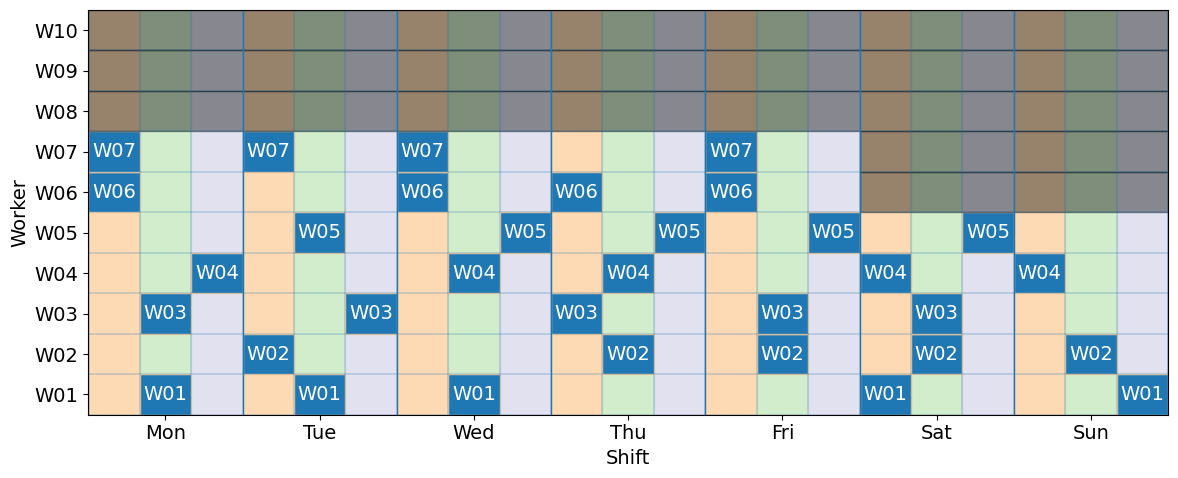

In [3]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle


def visualize(m):
    bw = 1.0
    workers = [worker for worker in m.W]
    plt.rcParams["font.size"] = 14
    fig, ax = plt.subplots(1, 1, figsize=(12, 2 + 0.3 * len(m.W)))

    colormap = plt.cm.tab20c.colors
    colors = [colormap[7], colormap[11], colormap[15]]
    for i in range(len(m.T) + 1):
        ax.axvline(i, lw=0.3)
        ax.fill_between(
            [i, i + 1], [0] * 2, [len(m.W)] * 2, alpha=0.8, color=colors[i % 3]
        )
    for i in range(len(m.D) + 1):
        ax.axvline(3 * i, lw=1)

    ax.set_xlim(0, len(m.T))
    ax.set_xticks([3 * i + 1.5 for i in range(len(m.D))])
    ax.set_xticklabels(m.D)
    ax.set_xlabel("Shift")

    ax.set_ylim(0, len(m.W))
    for j in range(len(m.W) + 1):
        ax.axhline(j, lw=0.3)
    ax.set_yticks([j + 0.5 for j in range(len(m.W))])
    ax.set_yticklabels(workers)
    ax.set_ylabel("Worker")

    # show shift assignments
    for i, slot in enumerate(m.T):
        day, shift = slot
        for j, worker in enumerate(m.W):
            if round(m.a[worker, day, shift]()):
                ax.add_patch(
                    Rectangle((i, j + (1 - bw) / 2), 1, bw, edgecolor=colors[0])
                )
                ax.text(
                    i + 1 / 2, j + 1 / 2, worker, ha="center", va="center", color="w"
                )

    # display needed and weekend data
    for j, worker in enumerate(m.W):
        if not m.n[worker]():
            ax.fill_between([0, len(m.T)], [j, j], [j + 1, j + 1], color="k", alpha=0.4)
        if m.n[worker]() and not m.e[worker]():
            ax.fill_between(
                [15, len(m.T)], [j, j], [j + 1, j + 1], color="k", alpha=0.4
            )
    plt.tight_layout()
    plt.show()


visualize(m)

## Implementing the schedule with reports

Optimal planning models can generate large amounts of data that need to be summarized and communicated to individuals for implementation. 

### Creating a master schedule with categorical data

The following cell creates a pandas DataFrame comprising all active assignments from the solved model. The data consists of all (worker, day, shift) tuples for which the binary decision variable `m.a` equals one. The data is categorical consisting of a unique id for each worker, a day of the week, or the name of a shift. Each of the categories has a natural ordering that should be used in creating reports. This is implemented using the `CategoricalDtype` class.

In [4]:
import pandas as pd

schedule = pd.DataFrame(
    [[w, d, s] for w in m.W for d, s in m.T if m.a[w, d, s]()],
    columns=["worker", "day", "shift"],
)

# create and assign a worker category type
worker_type = pd.CategoricalDtype(categories=m.W, ordered=True)
schedule["worker"] = schedule["worker"].astype(worker_type)

# create and assign a day category type
day_type = pd.CategoricalDtype(categories=m.D, ordered=True)
schedule["day"] = schedule["day"].astype(day_type)

# create and assign a shift category type
shift_type = pd.CategoricalDtype(categories=m.S, ordered=True)
schedule["shift"] = schedule["shift"].astype(shift_type)

# demonstrate sorting and display of the master schedule
schedule.sort_values(by=["day", "shift", "worker"])

,worker,day,shift
25,W06,Mon,morning
29,W07,Mon,morning
0,W01,Mon,evening
10,W03,Mon,evening
15,W04,Mon,night
5,W02,Tue,morning
30,W07,Tue,morning
1,W01,Tue,evening
20,W05,Tue,evening
11,W03,Tue,night


### Reports for workers

Each worker should receive a report detailing their shift assignments. The reports are created by sorting the master schedule by worker, day, and shift, then grouping by worker. 

In [5]:
# sort schedule by worker
schedule = schedule.sort_values(by=["worker", "day", "shift"])

# print worker schedules
for worker, worker_schedule in schedule.groupby("worker"):
    print(f"\nWork schedule for {worker}")
    if len(worker_schedule) > 0:
        for s in worker_schedule.to_string(index=False).split("\n"):
            print(s)
    else:
        print("   no assigned shifts")


Work schedule for W01
worker day   shift
   W01 Mon evening
   W01 Tue evening
   W01 Wed evening
   W01 Sat morning
   W01 Sun   night

Work schedule for W02
worker day   shift
   W02 Tue morning
   W02 Thu evening
   W02 Fri evening
   W02 Sat evening
   W02 Sun evening

Work schedule for W03
worker day   shift
   W03 Mon evening
   W03 Tue   night
   W03 Thu morning
   W03 Fri evening
   W03 Sat evening

Work schedule for W04
worker day   shift
   W04 Mon   night
   W04 Wed evening
   W04 Thu evening
   W04 Sat morning
   W04 Sun morning

Work schedule for W05
worker day   shift
   W05 Tue evening
   W05 Wed   night
   W05 Thu   night
   W05 Fri   night
   W05 Sat   night

Work schedule for W06
worker day   shift
   W06 Mon morning
   W06 Wed morning
   W06 Thu morning
   W06 Fri morning

Work schedule for W07
worker day   shift
   W07 Mon morning
   W07 Tue morning
   W07 Wed morning
   W07 Fri morning

Work schedule for W08
   no assigned shifts

Work schedule for W09
   no assig

### Reports for store managers

The store managers need reports listing workers by assigned day and shift.

In [6]:
# sort by day, shift, worker
schedule = schedule.sort_values(by=["day", "shift", "worker"])

for day, day_schedule in schedule.groupby("day"):
    print(f"\nShift schedule for {day}")
    for shift, shift_schedule in day_schedule.groupby("shift"):
        print(f"   {shift} shift: ", end="")
        print(", ".join([worker for worker in shift_schedule["worker"].values]))


Shift schedule for Mon
   morning shift: W06, W07
   evening shift: W01, W03
   night shift: W04

Shift schedule for Tue
   morning shift: W02, W07
   evening shift: W01, W05
   night shift: W03

Shift schedule for Wed
   morning shift: W06, W07
   evening shift: W01, W04
   night shift: W05

Shift schedule for Thu
   morning shift: W03, W06
   evening shift: W02, W04
   night shift: W05

Shift schedule for Fri
   morning shift: W06, W07
   evening shift: W02, W03
   night shift: W05

Shift schedule for Sat
   morning shift: W01, W04
   evening shift: W02, W03
   night shift: W05

Shift schedule for Sun
   morning shift: W04
   evening shift: W02
   night shift: W01
